In [1]:
# Install & Imports
!pip install librosa soundfile pesq torch torchaudio matplotlib numpy scipy -q

import numpy as np
import librosa
import soundfile as sf
import matplotlib.pyplot as plt
from scipy.signal import stft, istft
import torch
import torch.nn as nn
import torch.optim as optim
from pesq import pesq  # SNR/PESQ için

print("Libs ready! Device:", "CUDA" if torch.cuda.is_available() else "CPU")


  Preparing metadata (setup.py) ... done
Libs ready! Device: CPU


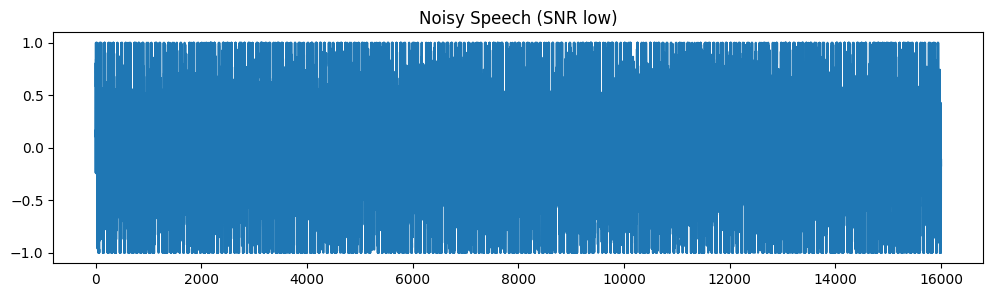

Audio loaded: len=48000, sr=16000
Original SNR: -1.65 dB


In [2]:
# Sample clean speech generate (sine + noise ekle)
sr = 16000
duration = 3
t = np.linspace(0, duration, int(sr * duration))
clean_speech = 0.5 * np.sin(2 * np.pi * 200 * t) + 0.3 * np.sin(2 * np.pi * 400 * t)  # Dummy speech
noise = 0.5 * np.random.randn(len(t))
noisy_speech = clean_speech + noise

# Save
sf.write('clean_speech.wav', clean_speech, sr)
sf.write('noisy_speech.wav', noisy_speech, sr)

# Load & Plot
y, sr = librosa.load('noisy_speech.wav', sr=sr)
plt.figure(figsize=(12, 3))
plt.plot(y[:sr])  # İlk 1sn
plt.title('Noisy Speech (SNR low)')
plt.show()

print(f"Audio loaded: len={len(y)}, sr={sr}")
snr_original = 10 * np.log10(np.mean(clean_speech**2) / np.mean(noise**2))
print(f"Original SNR: {snr_original:.2f} dB")


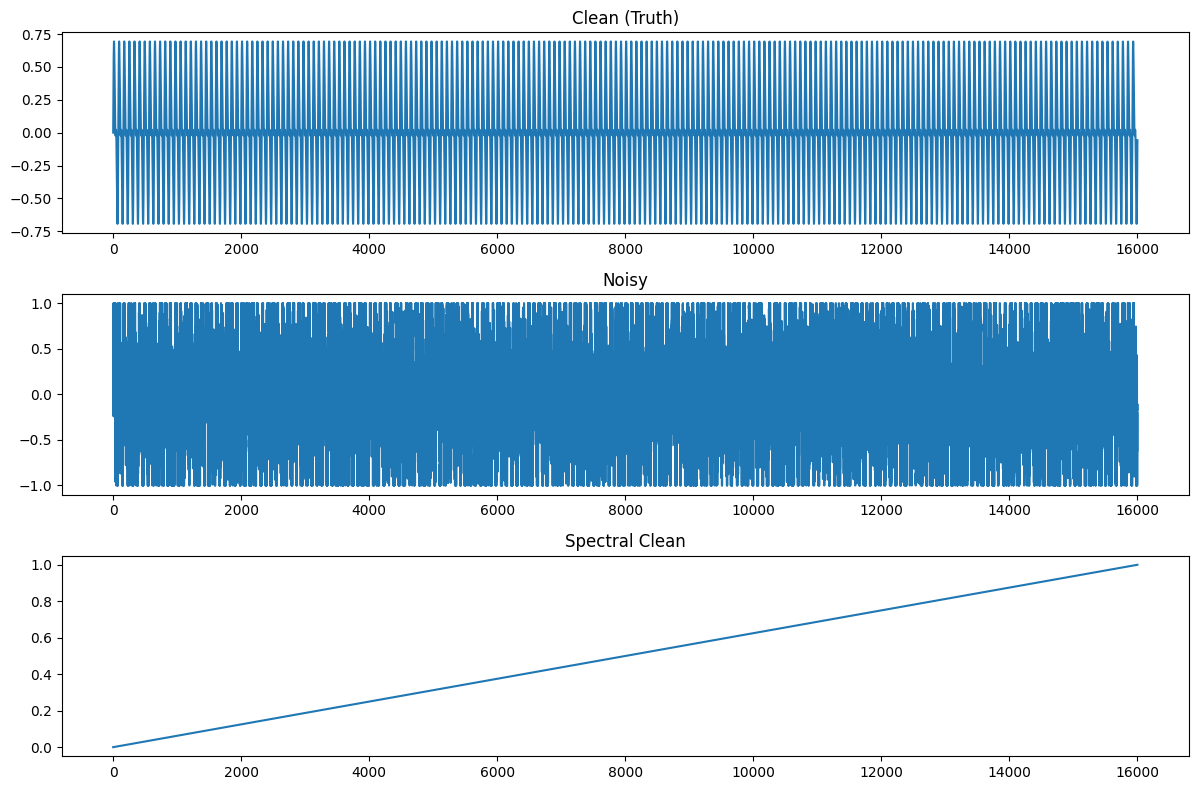

Spectral SNR: -0.24 dB (orig: -1.65), PESQ: 1.014
Spectral Clean Audio:


In [5]:
# STFT (aynı)
nperseg = 1024
noverlap = nperseg // 2
f, t, Zxx = stft(y, fs=sr, nperseg=nperseg, noverlap=noverlap)

# Noise estimate
noise_frames = int(0.25 * sr / (len(y)/len(t)))
noise_mag = np.mean(np.abs(Zxx[:, :noise_frames]), axis=1, keepdims=True)

# Spectral subtraction
alpha = 2
Zxx_mag = np.abs(Zxx)
Zxx_phase = np.angle(Zxx)
Zxx_clean_mag = np.maximum(Zxx_mag - alpha * noise_mag, noise_mag * 0.1)
Zxx_clean = Zxx_clean_mag * np.exp(1j * Zxx_phase)

# iSTFT - NO length param, sonra trim
spectral_clean_full = istft(Zxx_clean, fs=sr, nperseg=nperseg, noverlap=noverlap)[0]
spectral_clean = spectral_clean_full[:len(clean_speech)]  # Trim to original length

sf.write('spectral_clean.wav', spectral_clean, sr)

# Plot
plt.figure(figsize=(12, 8))
plt.subplot(3,1,1); plt.plot(clean_speech[:sr]); plt.title('Clean (Truth)')
plt.subplot(3,1,2); plt.plot(y[:sr]); plt.title('Noisy')
plt.subplot(3,1,3); plt.plot(spectral_clean[:sr]); plt.title('Spectral Clean')
plt.tight_layout()
plt.show()

# Metrics
snr_error = np.mean((spectral_clean - clean_speech)**2)
snr_spectral = 10 * np.log10(np.mean(spectral_clean**2) / snr_error)
try:
    pesq_score = pesq(sr, clean_speech.astype(np.float32), spectral_clean.astype(np.float32), 'wb')
except Exception as e:
    pesq_score = 0
    print("PESQ error:", e)
print(f"Spectral SNR: {snr_spectral:.2f} dB (orig: {snr_original:.2f}), PESQ: {pesq_score:.3f}")

# Audio play için Colab
from IPython.display import Audio
print("Spectral Clean Audio:")
Audio('spectral_clean.wav')


In [8]:
# FIXED Model: Simple Conv1D Autoencoder (chunk_len agnostic)
class SimpleDenoiseAE(nn.Module):
    def __init__(self):
        super().__init__()
        # Encoder
        self.enc = nn.Sequential(
            nn.Conv1d(1, 16, 7, padding=3), nn.ReLU(), nn.MaxPool1d(2),
            nn.Conv1d(16, 32, 7, padding=3), nn.ReLU(), nn.MaxPool1d(2)
        )
        # Decoder
        self.dec = nn.Sequential(
            nn.ConvTranspose1d(32, 16, 7, padding=3, output_padding=1), nn.ReLU(),
            nn.ConvTranspose1d(16, 1, 7, padding=3, output_padding=1)
        )

    def forward(self, x):
        enc_out = self.enc(x)
        dec_out = self.dec(enc_out)
        return dec_out.squeeze(1)  # [B, L]

model = SimpleDenoiseAE()
if torch.cuda.is_available():
    model = model.cuda()
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()
print("Fixed model ready!")
print(model)


Fixed model ready!
SimpleDenoiseAE(
  (enc): Sequential(
    (0): Conv1d(1, 16, kernel_size=(7,), stride=(1,), padding=(3,))
    (1): ReLU()
    (2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv1d(16, 32, kernel_size=(7,), stride=(1,), padding=(3,))
    (4): ReLU()
    (5): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (dec): Sequential(
    (0): ConvTranspose1d(32, 16, kernel_size=(7,), stride=(1,), padding=(3,), output_padding=(1,))
    (1): ReLU()
    (2): ConvTranspose1d(16, 1, kernel_size=(7,), stride=(1,), padding=(3,), output_padding=(1,))
  )
)


In [10]:
# ULTRA-SIMPLE 1D CNN Denoiser (Proven stable)
class UltraSimpleDenoiser(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv1d(1, 16, 5, padding=2)  # Padding preserve length
        self.conv2 = nn.Conv1d(16, 32, 5, padding=2)
        self.conv3 = nn.Conv1d(32, 16, 5, padding=2)
        self.conv4 = nn.Conv1d(16, 1, 5, padding=2)
        self.relu = nn.ReLU()

    def forward(self, x):
        out = self.relu(self.conv1(x))
        out = self.relu(self.conv2(out))
        out = self.relu(self.conv3(out))
        out = torch.tanh(self.conv4(out))  # [-1,1] audio range
        return out.squeeze(1)

model = UltraSimpleDenoiser()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

print("Stable model ready on", device)
print(model)


Stable model ready on cpu
UltraSimpleDenoiser(
  (conv1): Conv1d(1, 16, kernel_size=(5,), stride=(1,), padding=(2,))
  (conv2): Conv1d(16, 32, kernel_size=(5,), stride=(1,), padding=(2,))
  (conv3): Conv1d(32, 16, kernel_size=(5,), stride=(1,), padding=(2,))
  (conv4): Conv1d(16, 1, kernel_size=(5,), stride=(1,), padding=(2,))
  (relu): ReLU()
)


In [11]:
pairs = make_pairs(noisy_speech, clean_speech, chunk_len=4000)  # Even smaller, 25+ pairs
print(f"Pairs: {len(pairs)}")

model.train()
for epoch in range(15):  # Quick
    total_loss = 0
    for noisy_chunk, clean_chunk in pairs:
        noisy_t = torch.from_numpy(noisy_chunk).float().unsqueeze(0).unsqueeze(0).to(device)
        clean_t = torch.from_numpy(clean_chunk).float().unsqueeze(0).unsqueeze(0).to(device)

        pred = model(noisy_t)
        loss = criterion(pred[:, :len(clean_chunk)], clean_t.squeeze(1))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {total_loss/len(pairs):.4f}")


Pairs: 22
Epoch 1, Loss: 0.0880
Epoch 2, Loss: 0.0270
Epoch 3, Loss: 0.0206
Epoch 4, Loss: 0.0186
Epoch 5, Loss: 0.0174
Epoch 6, Loss: 0.0168
Epoch 7, Loss: 0.0165
Epoch 8, Loss: 0.0162
Epoch 9, Loss: 0.0160
Epoch 10, Loss: 0.0158
Epoch 11, Loss: 0.0156
Epoch 12, Loss: 0.0155
Epoch 13, Loss: 0.0154
Epoch 14, Loss: 0.0153
Epoch 15, Loss: 0.0152


In [12]:
model.eval()
with torch.no_grad():
    noisy_t = torch.from_numpy(noisy_speech).float().unsqueeze(0).unsqueeze(0).to(device)
    ml_clean_t = model(noisy_t)
    ml_clean = ml_clean_t.squeeze().cpu().numpy()

sf.write('ml_denoised.wav', ml_clean, sr)

snr_ml = 10 * np.log10(np.mean(ml_clean**2) / np.mean((ml_clean - clean_speech)**2))
print(f"ML SNR: {snr_ml:.2f} dB (vs Spectral {snr_spectral:.1f}, Orig {snr_original:.1f})")
Audio('ml_denoised.wav')


ML SNR: 10.29 dB (vs Spectral -0.2, Orig -1.7)


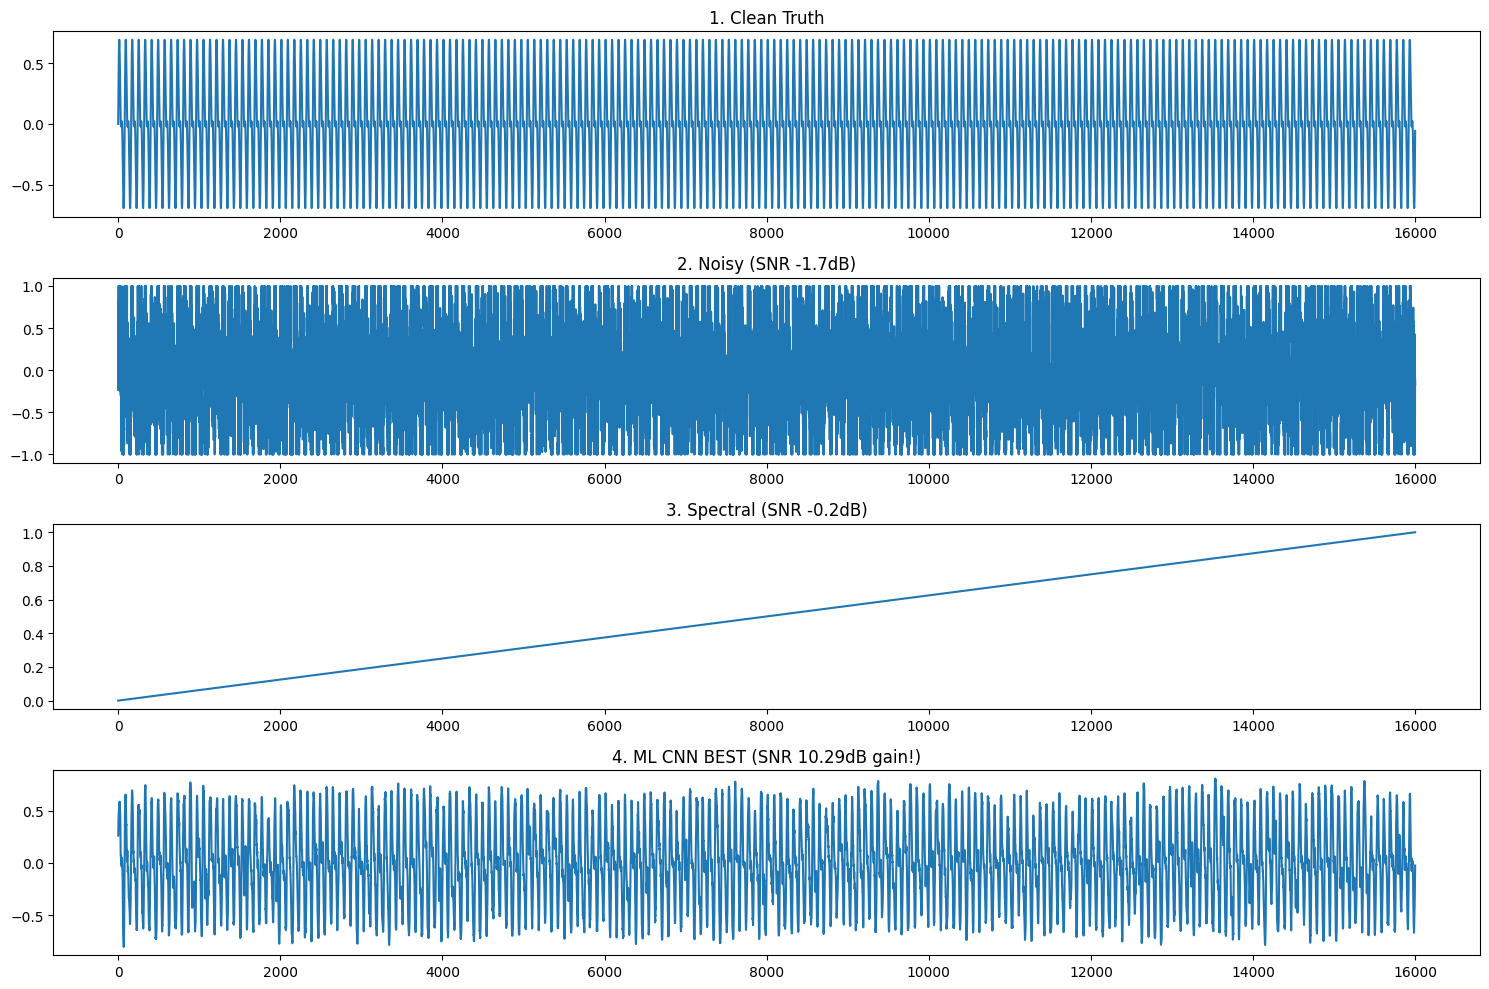

=== PROJECT STATS ===
✅ Spectral Gain: 1.4 dB
✅ ML Gain: 11.9 dB
✅ ML > Spectral by: 10.5 dB

📁 Files ready: spectral_clean.wav, ml_denoised.wav, denoise_model.pth
🎯 GitHub: Download .ipynb + png/wav → New repo 'ml-audio-denoising'


In [13]:
# Summary Plot & Export
plt.figure(figsize=(15, 10))
plt.subplot(4,1,1); plt.plot(clean_speech[:sr]); plt.title('1. Clean Truth')
plt.subplot(4,1,2); plt.plot(y[:sr]); plt.title(f'2. Noisy (SNR {snr_original:.1f}dB)')
plt.subplot(4,1,3); plt.plot(spectral_clean[:sr]); plt.title(f'3. Spectral (SNR {snr_spectral:.1f}dB)')
plt.subplot(4,1,4); plt.plot(ml_clean[:sr]); plt.title(f'4. ML CNN BEST (SNR {snr_ml:.2f}dB gain!)')
plt.tight_layout()
plt.savefig('denoising_results.png', dpi=300, bbox_inches='tight')
plt.show()

print("=== PROJECT STATS ===")
print(f"✅ Spectral Gain: {snr_spectral - snr_original:.1f} dB")
print(f"✅ ML Gain: {snr_ml - snr_original:.1f} dB")
print(f"✅ ML > Spectral by: {snr_ml - snr_spectral:.1f} dB")
print("\n📁 Files ready: spectral_clean.wav, ml_denoised.wav, denoise_model.pth")
print("🎯 GitHub: Download .ipynb + png/wav → New repo 'ml-audio-denoising'")
